In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Defining Constants

In [22]:
DATA_DIR = "../FinalCsvFiles"
PYTHIA_ALL_SNAPSHOTS_FILE = "All_models_implicit_explicit_all_snapshots_noLineBreak.csv"
ALL_MODELS_FINAL_SNAPSHOT = "gpt_opt_falcon_pythia_implicit_explicit.csv"
ACL_FIGURE_SIZE=[4, 3]

class Fields:
    # CSV existing fields
    DATASET = "dataset"
    MODEL = "model"
    SIZE = "size"
    FULL_MODEL_NAME = "full model name"
    SNAPSHOT = "snapshot"
    REPETITION_PENALTY = "repetition_penalty"
    SEED = "seed"
    GENERATED_TEXT = "generated_text"
    NEW_TOKENS_ONLY = "new_tokens_only"
    GENERATED_NUMBERS = "generated_numbers"
    FIRST_GENERATED_NUMBER = "first_generated_number"
    HAS_SINGLE_NUMBER = "has_single_number"
    HAS_ANSWER = "has_answer"
    REPETITION_SYNDROME = "repetition_syndrome"
    DIFF_FROM_ANSWER = "diff_from_answer"
    RIGHT_DIRECTION = "right_direction"
    TEMPLATE_ID = "template_id"
    TEXT = "text"
    NUM1 = "num1"
    OPERATOR = "operator"
    NUM2 = "num2"
    ANSWER = "answer"
    ANSWER_STR = "answer_str"
    NUMBER_FORMAT = "number_format"
    ITEMS = "items"
    VERB = "verb"
    ID = "id"

    # To be created fields
    TRAINING_PROGRESS = "Training Progress"
    MIN_OPERATOR_ACC = "Min Operator Accuracy"
    PORTION = "Portion"
    ACC = "Accuracy"
    TS_INDEX = "TS-index"


#### TS INDEX calculation

In [31]:
def get_TS_index_by(by_fields, df):
    NUM_OF_TEMPLATES = 10

    # Add field "Accuracy" - accuracy by template id and by op
    df_acc_by_operator = df.groupby(by_fields + [Fields.TEMPLATE_ID, Fields.OPERATOR])[Fields.HAS_ANSWER].mean().reset_index(name=Fields.ACC)

    # Add field "Min Operator Accuracy" - minimal accuracy between the operators per template
    df_min_operator_acc = (df_acc_by_operator.groupby(by_fields + [Fields.TEMPLATE_ID])
                          [Fields.ACC].min()
                           .reset_index(name=Fields.MIN_OPERATOR_ACC))

    # Add field "Portion" - the portion of templates with
    # Min Operator Accuracy up to its accuracy
    df_min_operator_acc[Fields.PORTION] = (df_min_operator_acc.groupby(by_fields)[Fields.MIN_OPERATOR_ACC] \
                   .rank(method="first", ascending=False)
                   .div(NUM_OF_TEMPLATES))




    # TS_index is the maximal accuracy that is lower than it's corresponding portion
    mask = df_min_operator_acc[Fields.MIN_OPERATOR_ACC] < df_min_operator_acc[Fields.PORTION]
    ts_indices = df_min_operator_acc[mask].groupby(by_fields)[Fields.MIN_OPERATOR_ACC].max().reset_index(name=Fields.TS_INDEX)

    return ts_indices

# Pythia Models - Through The Training

#### Load

In [4]:
# Load CSV into pandas DataFrame
df = pd.read_csv(f"{DATA_DIR}/{PYTHIA_ALL_SNAPSHOTS_FILE}")

df[Fields.RIGHT_DIRECTION] = df[Fields.RIGHT_DIRECTION].fillna(False)
df[Fields.TRAINING_PROGRESS] = (df[Fields.SNAPSHOT] / 143000) * 100
implicit_df = df[df[Fields.DATASET]=="implicit_small"]
explicit_df = df[df[Fields.DATASET]=="explicit_small"]

# print(df.head())
# print(df.dtypes)


/var/folders/g7/5n_f078n3_jgq19mkdyk2jhm0000gn/T/ipykernel_5056/2319632088.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[Fields.RIGHT_DIRECTION] = df[Fields.RIGHT_DIRECTION].fillna(False)


#### Create accuracy plots

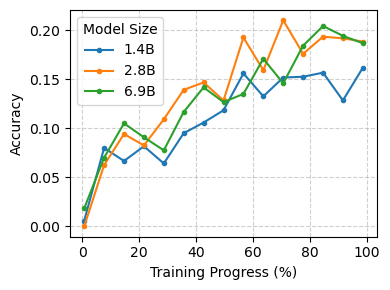

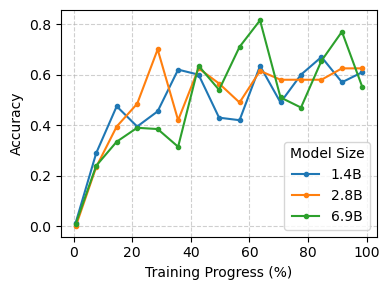

In [23]:
for dataset, dataset_name in [(implicit_df, "implicit"), (explicit_df, "explicit")]:
    table = dataset.pivot_table(values=Fields.HAS_ANSWER,
                                    index=Fields.TRAINING_PROGRESS,
                                    columns=Fields.SIZE, aggfunc="mean")

    table.plot(kind="line", marker=".", figsize=ACL_FIGURE_SIZE)
    #plt.title(f"Pythia accuracy on the {dataset_name} Dataset")
    plt.xlabel("Training Progress (%)")
    plt.ylabel("Accuracy")
    plt.legend(title="Model Size")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"analysis_output/{dataset_name}_training.png")
plt.show()

#### Accuracy by template and operator (final snapshot)
For the appendix - comparison between 2.8 and 6.9

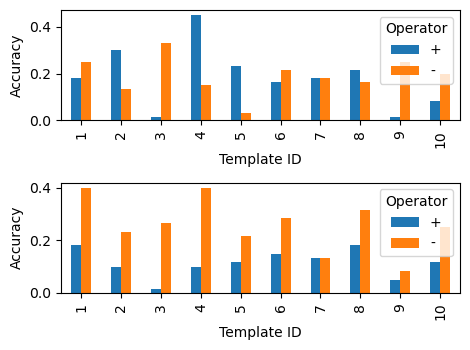

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[n*1.2 for n in ACL_FIGURE_SIZE])

for model_size, axis in zip(["2.8B", "6.9B"], [ax1, ax2]):
    filtered = implicit_df[implicit_df[Fields.SNAPSHOT] == 141000]
    filtered = filtered[filtered[Fields.SIZE] == model_size]
    filtered = filtered[filtered[Fields.DATASET] == "implicit_small"]

    table = filtered.pivot_table(values=Fields.HAS_ANSWER,
                          index=Fields.TEMPLATE_ID,
                          columns=Fields.OPERATOR, aggfunc="mean")
    table.plot(kind="bar", ax=axis)
    #plt.title(f"Pythia final snapshot success per template and operator")
    axis.set_xlabel("Template ID")
    axis.set_ylabel("Accuracy")
    axis.legend(title="Operator")
plt.tight_layout()
plt.savefig(f"analysis_output/imbalnce_2.8_vs_6.9.png")


For the evaluation - explaining TS-index

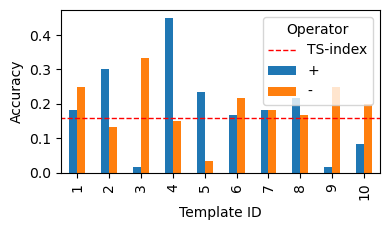

In [38]:
filtered = implicit_df[implicit_df[Fields.SNAPSHOT] == 141000]
filtered = filtered[filtered[Fields.SIZE] == "2.8B"]

table = filtered.pivot_table(values=Fields.HAS_ANSWER,
                      index=Fields.TEMPLATE_ID,
                      columns=Fields.OPERATOR, aggfunc="mean")
figure_size = ACL_FIGURE_SIZE.copy()
figure_size[1] *= 0.8

table.plot(kind="bar", figsize=figure_size)
plt.xlabel("Template ID")
plt.ylabel("Accuracy")
plt.hlines(y=0.16, color="red", linestyle="--", linewidth=1, xmin=-1, xmax=10, label=Fields.TS_INDEX)
plt.legend(title="Operator")
plt.tight_layout()
plt.savefig(f"analysis_output/ts_explanation.png")

### Comparing to the explicit questions

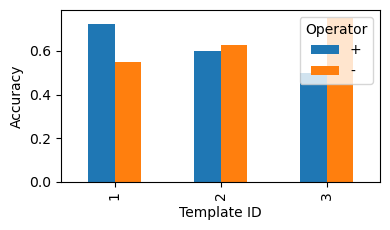

In [40]:
filtered = explicit_df[explicit_df[Fields.SNAPSHOT] == 141000]
filtered = filtered[filtered[Fields.SIZE] == "2.8B"]

table = filtered.pivot_table(values=Fields.HAS_ANSWER,
                      index=Fields.TEMPLATE_ID,
                      columns=Fields.OPERATOR, aggfunc="mean")
figure_size = ACL_FIGURE_SIZE.copy()
figure_size[1] *= 0.8

table.plot(kind="bar", figsize=figure_size)
plt.xlabel("Template ID")
plt.ylabel("Accuracy")
plt.legend(title="Operator")
plt.tight_layout()
plt.savefig(f"analysis_output/explicit_breakdown.png")

#### TS INDEX by snapshot per model size

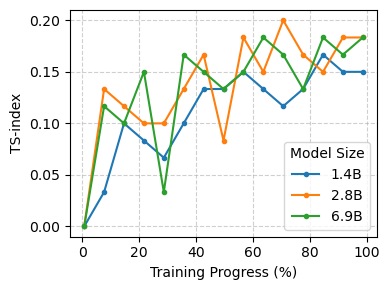

In [32]:
ts_indices = get_TS_index_by([Fields.SIZE, Fields.TRAINING_PROGRESS], implicit_df)

table = ts_indices.pivot_table(values=Fields.TS_INDEX,
                                              index=Fields.TRAINING_PROGRESS,
                                              columns=Fields.SIZE, aggfunc="max")

table.plot(kind="line", marker=".", figsize=ACL_FIGURE_SIZE)
#plt.title(f"Pythia TS-index")
plt.xlabel("Training Progress (%)")
plt.ylabel("TS-index")
plt.legend(title="Model Size")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"analysis_output/implicit_training_ts.png")

In [9]:
# TODO - Show operator imbalance through training, net and variance by template
# TODO - Calculate success and TS-index for other models

# GPT, OPT, Falcon, Pythia

In [10]:
# Load CSV into pandas DataFrame
df = pd.read_csv(f"{DATA_DIR}/{ALL_MODELS_FINAL_SNAPSHOT}")

df[Fields.RIGHT_DIRECTION] = df[Fields.RIGHT_DIRECTION].fillna(False)
df[Fields.TRAINING_PROGRESS] = (df[Fields.SNAPSHOT] / 143000) * 100


/var/folders/g7/5n_f078n3_jgq19mkdyk2jhm0000gn/T/ipykernel_5056/2268683302.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[Fields.RIGHT_DIRECTION] = df[Fields.RIGHT_DIRECTION].fillna(False)


### Overall Accuracy Rate

In [11]:
table = df.pivot_table(values=Fields.HAS_ANSWER,
                                              index=Fields.FULL_MODEL_NAME,
                                              columns=Fields.DATASET, aggfunc="mean")

print(table)

dataset                         explicit_small  implicit_small
full model name                                               
EleutherAI/pythia-1.4b-deduped           0.610        0.161667
EleutherAI/pythia-2.8b-deduped           0.625        0.188333
EleutherAI/pythia-6.9b-deduped           0.550        0.186667
facebook/opt-1.3b                        0.190        0.094167
facebook/opt-125m                        0.210        0.028333
gpt2-medium                              0.305        0.183333
tiiuae/Falcon3-1B-Base                   0.990        0.576667


### TS-Index

In [33]:
implicit_df_all_models = df[df[Fields.DATASET]=="implicit_small"]

ts_indices = get_TS_index_by([Fields.FULL_MODEL_NAME], implicit_df_all_models)

print(ts_indices.to_string())

                  full model name  TS-index
0  EleutherAI/pythia-1.4b-deduped  0.150000
1  EleutherAI/pythia-2.8b-deduped  0.183333
2  EleutherAI/pythia-6.9b-deduped  0.183333
3               facebook/opt-1.3b  0.100000
4               facebook/opt-125m  0.000000
5                     gpt2-medium  0.183333
6          tiiuae/Falcon3-1B-Base  0.433333


### Imbalance mean and stddev

In [13]:
accuracies = implicit_df_all_models.pivot_table(values=Fields.HAS_ANSWER,
                      index=[Fields.FULL_MODEL_NAME, Fields.TEMPLATE_ID],
                      columns=Fields.OPERATOR, aggfunc="mean")


accuracies["Max"] =  accuracies[["+","-"]].max(axis=1)
accuracies["Relative_Diff"] = abs(accuracies["+"] - accuracies["-"]) / accuracies["Max"]

imbalance = accuracies.groupby(Fields.FULL_MODEL_NAME)["Relative_Diff"].agg(["mean", "std"]).reset_index()

print(imbalance.to_string())



                  full model name      mean       std
0  EleutherAI/pythia-1.4b-deduped  0.313495  0.237186
1  EleutherAI/pythia-2.8b-deduped  0.527424  0.332922
2  EleutherAI/pythia-6.9b-deduped  0.508711  0.242596
3               facebook/opt-1.3b  0.695352  0.380223
4               facebook/opt-125m  1.000000  0.000000
5                     gpt2-medium  0.722545  0.217244
6          tiiuae/Falcon3-1B-Base  0.378748  0.231219
